In [11]:
# filename: bayesian_ads.ipynb
# purpose: Bayesian analysis template for marketing clients
# author: Atma
# date: 2025-07-09

In [12]:
# Cell 1: Imports & Environment
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load API keys / configs
load_dotenv()
# Adjust plot style for readability
plt.style.use ('seaborn-v0_8-whitegrid')

In [13]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')


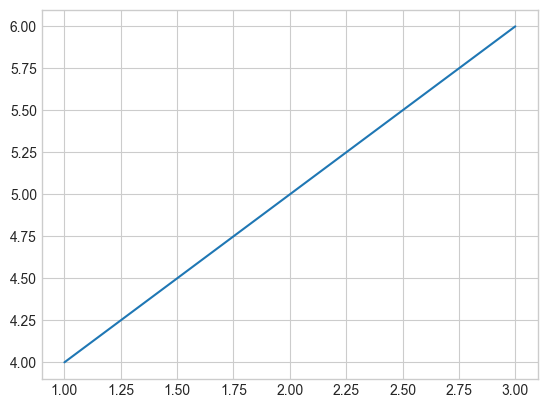

In [15]:
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()


In [16]:
# Cell 2: Data Loading

from modules.data_loader import (
    load_meta_ads_data,
    load_linkedin_campaign_data,
    load_ga4_data
)

# Test each stub
df_meta = load_meta_ads_data()
df_linkedin = load_linkedin_campaign_data()
df_ga4 = load_ga4_data()

print(df_meta.head())
print(df_linkedin.head())
print(df_ga4.head())

  ad_name  impressions  clicks
0    Ad A         1000      92
1    Ad B         1050      78
  campaign_name  impressions  clicks
0    Campaign 1          500      40
1    Campaign 2          650      55
  page_path  users  sessions
0     /home    200       220
1  /landing    180       200


In [17]:
# Cell 3: Bayesian Functions

from scipy.stats import beta


def compute_posterior(alpha_prior, beta_prior, clicks, impressions):
    """
    Compute alpha and beta of the posterior Beta distribution.
    """
    alpha_post = alpha_prior + clicks
    beta_post = beta_prior + impressions - clicks
    return alpha_post, beta_post

# Example usage
a_alpha, a_beta = compute_posterior(1, 1, 92, 1000)
a_alpha, a_beta

(93, 909)

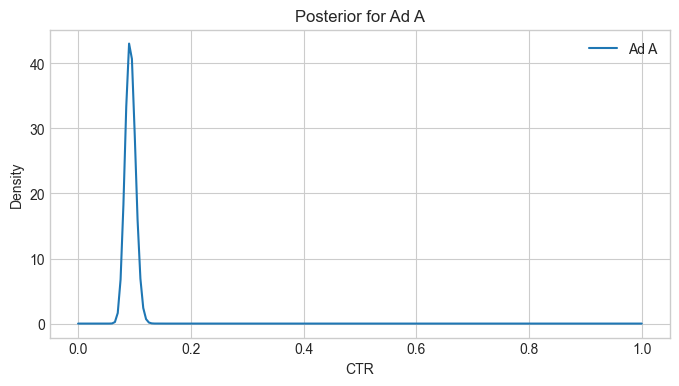

In [18]:
# Cell 4: Posterior Plotting

from modules.visualization import plot_posterior, save_posterior_plot

alpha_a, beta_a = compute_posterior(1, 1, 92, 1000)
save_posterior_plot(alpha_a, beta_a, 'Ad A', 'outputs/charts/posterior_Ad_A.png')
plot_posterior(alpha_a, beta_a, 'Ad A')




In [19]:
# Cell 5: GPT Analysis
from modules.openai_client import generate_insight_narrative

# Build summary dict
summary = {
    'Ad A': {'clicks': 92, 'impr': 1000, 'alpha': alpha_a, 'beta': beta_a}
}

narrative = generate_insight_narrative(summary)
print(narrative)

Our ad performance summary shows that Ad A had a total of 92 clicks out of 1000 impressions, with an alpha value of 93 and a beta value of 909. This indicates that the ad was able to capture the attention of a significant portion of our target audience, resulting in a high click-through rate.

The high alpha value suggests that the ad resonated well with our audience and effectively communicated our message. On the other hand, the beta value indicates that there is still room for improvement in terms of reaching a larger audience and maximizing the ad's potential impact.

Moving forward, our marketing team should analyze the factors that contributed to the success of Ad A and leverage them in future campaigns. Additionally, we should consider ways to optimize the ad to increase its reach and engagement, ultimately driving more conversions and achieving our marketing goals. By learning from the performance of Ad A, we can continue to refine our strategies and deliver even more impactful

In [20]:
# Cell 6: Generate Client Report

from modules.reporting import create_pdf_report

create_pdf_report(
    data_frame=df,
    posteriors={'Ad A': (alpha_a, beta_a)},
    narrative=narrative,
    output_path='outputs/Client_Report.pdf'
)
print("Report saved to outputs/Client_Report.pdf")



Report saved to outputs/Client_Report.pdf
